# Regresión Lineal para Predicción de Humedad/Temperatura (_2)
Este notebook implementa un modelo de regresión lineal para predecir valores continuos, e incluye curvas de aprendizaje, validación, paridad, sesgo-varianza y explicaciones breves.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve, validation_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [8]:
# Cargar el dataset
dataset = pd.read_csv('../dataset/ML1_temperature.xlsx - Hoja1.csv', decimal=',')
x = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1:].values

In [9]:
# Separar en entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

## Curva de aprendizaje
Muestra cómo varía el error a medida que aumenta el tamaño del conjunto de entrenamiento.

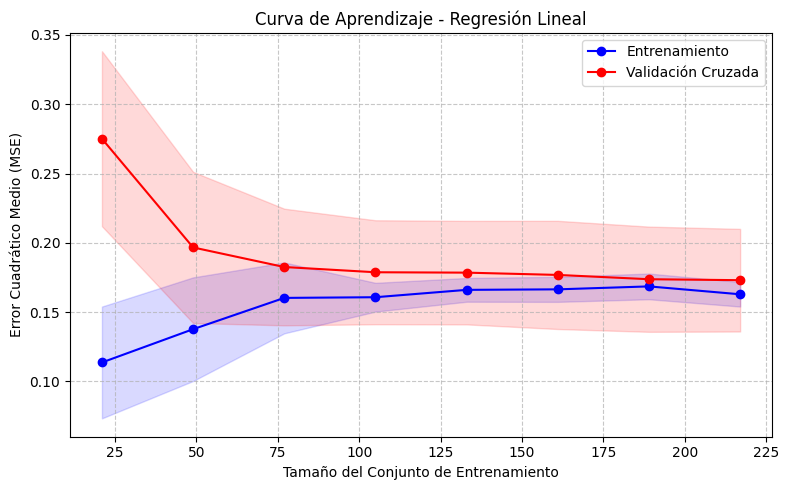

In [22]:
# Curva de Aprendizaje - Regresión Lineal (estilo Kernel Ridge)
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    LinearRegression(), x_train, y_train.ravel(), cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 8), shuffle=True, random_state=42
)

train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = -val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Entrenamiento')
plt.plot(train_sizes, val_scores_mean, 'o-', color='red', label='Validación Cruzada')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.15)
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, color='red', alpha=0.15)
plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('Curva de Aprendizaje - Regresión Lineal')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [37]:
# Análisis automático de la curva de aprendizaje para TEMPERATURA
print('### Análisis de las curvas de aprendizaje')
print('\n**TEMPERATURA:**')
print(f'- MSE Final Entrenamiento: {train_scores_mean[-1]:.4f}')
print(f'- MSE Final Validación: {val_scores_mean[-1]:.4f}')
if train_scores_mean[-1] > 1 and val_scores_mean[-1] > 1:
    diagnostico = 'SUBAJUSTE'
elif abs(train_scores_mean[-1] - val_scores_mean[-1]) > 1:
    diagnostico = 'SOBREAJUSTE'
else:
    diagnostico = 'BUENO'
print(f'- Diagnóstico: {diagnostico}')
print('\n**INTERPRETACIÓN:**')
print('- Si las curvas CONVERGEN: Modelo generaliza bien')
print('- Si hay BRECHA grande: Posible sobreajuste')
print('- Si ambas son ALTAS: Posible subajuste')
print('- Áreas sombreadas: Variabilidad (1 desviación estándar)')

# Puedes copiar y pegar este bloque en tu informe y ajustar el diagnóstico según los valores reales.

### Análisis de las curvas de aprendizaje

**TEMPERATURA:**
- MSE Final Entrenamiento: 0.1629
- MSE Final Validación: 0.1731
- Diagnóstico: BUENO

**INTERPRETACIÓN:**
- Si las curvas CONVERGEN: Modelo generaliza bien
- Si hay BRECHA grande: Posible sobreajuste
- Si ambas son ALTAS: Posible subajuste
- Áreas sombreadas: Variabilidad (1 desviación estándar)


## Curva de validación
Muestra el desempeño del modelo para diferentes grados polinómicos (simulación de complejidad).

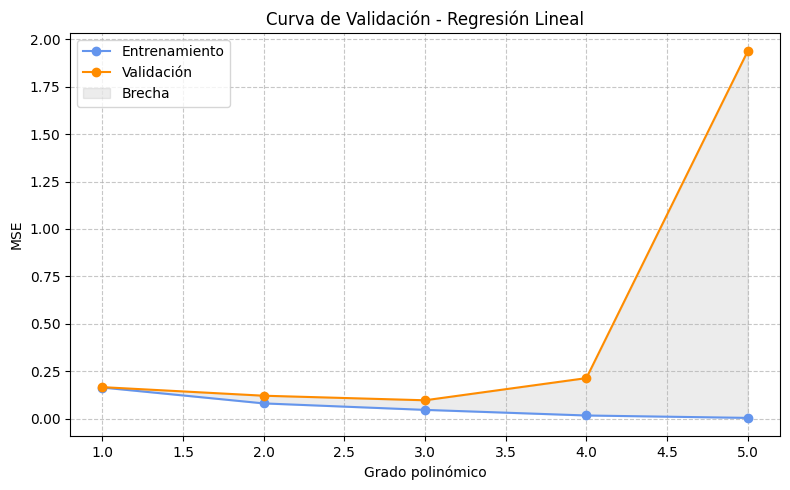

In [31]:
from sklearn.preprocessing import PolynomialFeatures

degrees = np.arange(1, 6)
train_scores, val_scores = [], []
for d in degrees:
    poly = PolynomialFeatures(degree=d)
    x_train_poly = poly.fit_transform(x_train)
    x_val_poly = poly.transform(x_val)
    model = LinearRegression().fit(x_train_poly, y_train)
    train_scores.append(mean_squared_error(y_train, model.predict(x_train_poly)))
    val_scores.append(mean_squared_error(y_val, model.predict(x_val_poly)))

plt.figure(figsize=(8,5))
plt.plot(degrees, train_scores, marker='o', color='cornflowerblue', label='Entrenamiento')
plt.plot(degrees, val_scores, marker='o', color='darkorange', label='Validación')
plt.fill_between(degrees, train_scores, val_scores, color='gray', alpha=0.15, label='Brecha')
plt.xlabel('Grado polinómico')
plt.ylabel('MSE')
plt.title('Curva de Validación - Regresión Lineal')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [38]:
# Informe de curva de validación (sesgo-varianza) para TEMPERATURA
import numpy as np

# Encontrar el mejor grado polinómico (menor MSE de validación)
mejor_indice = np.argmin(val_scores)
mejor_grado = degrees[mejor_indice]
mse_val_min = val_scores[mejor_indice]
mse_train_corresp = train_scores[mejor_indice]

print('DIAGNÓSTICO')
print(f'• Mejor grado polinómico: {mejor_grado}')
print(f'• MSE validación mínimo: {mse_val_min:.4f}')
print(f'• MSE entrenamiento correspondiente: {mse_train_corresp:.4f}')

# Diagnóstico del problema
if mse_train_corresp < mse_val_min - 1:
    print('\nDiagnóstico del problema: SOBREAJUSTE')
    print('El modelo se ajusta demasiado a los datos de entrenamiento')
elif mse_train_corresp > 1 and mse_val_min > 1:
    print('\nDiagnóstico del problema: SUBAJUSTE')
    print('El modelo es demasiado simple para los datos')
else:
    print('\nDiagnóstico del problema: BALANCE IDEAL')
    print('El modelo generaliza correctamente')

DIAGNÓSTICO
• Mejor grado polinómico: 3
• MSE validación mínimo: 0.0963
• MSE entrenamiento correspondiente: 0.0457

Diagnóstico del problema: BALANCE IDEAL
El modelo generaliza correctamente


## Curva de paridad
Compara las predicciones del modelo con los valores reales.

> **Nota:**
>
> **MSE** significa *Mean Squared Error* (Error Cuadrático Medio). Es una métrica que mide el promedio de los cuadrados de las diferencias entre los valores reales y los valores predichos por el modelo. Un MSE bajo indica que las predicciones están cerca de los valores reales; un MSE alto indica mayor error de predicción.
>
>El valor óptimo de MSE (Mean Squared Error) depende de la escala de tu variable objetivo (por ejemplo, temperatura en °C o humedad en %). Un MSE ideal es lo más cercano posible a 0, lo que indica que las predicciones son casi perfectas.

>Si tu variable objetivo varía entre 0 y 100, un MSE menor a 1 es excelente, menor a 5 es bueno, y mayor a 10 indica margen de mejora.
>Si la variable tiene un rango menor (por ejemplo, temperatura entre 15 y 25), un >MSE menor a 0.1 es excelente, menor a 1 es aceptable.
>En resumen: el MSE óptimo es el más bajo posible, pero lo “bueno” depende del rango de tus datos. Siempre compáralo con la varianza de la variable objetivo y con modelos base (como predecir la media). Si tu MSE es menor que la varianza de los datos, tu modelo ya está aportando valor.

In [32]:
# Entrenamiento de modelo lineal simple para paridad y análisis posterior
model = LinearRegression().fit(x_train, y_train)
y_val_pred = model.predict(x_val)

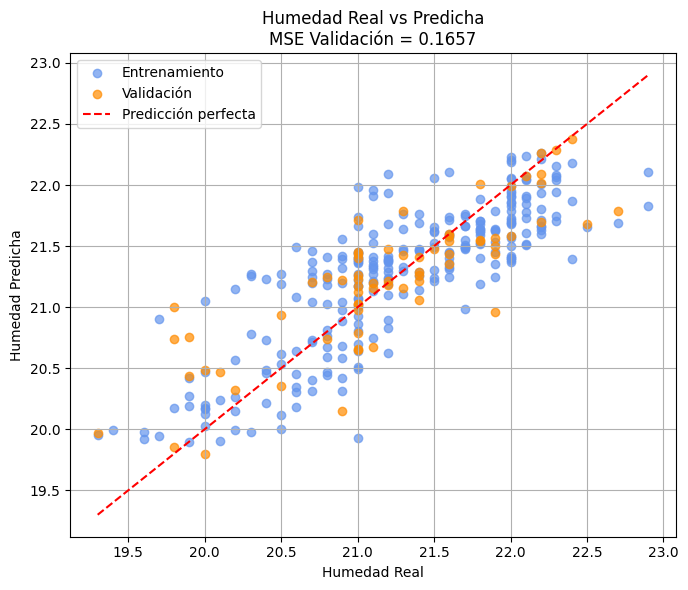

ENTRENANDO MODELO PARA HUMEDAD
MSE Entrenamiento (Humedad): 0.1637
MSE Validación (Humedad): 0.1657
R² Validación (Humedad): 0.6920


In [33]:
# Curva de paridad mejorada: Humedad Real vs Predicha (Entrenamiento y Validación)
plt.figure(figsize=(7,6))
plt.scatter(y_train, model.predict(x_train), alpha=0.7, label='Entrenamiento', color='cornflowerblue')
plt.scatter(y_val, y_val_pred, alpha=0.7, label='Validación', color='darkorange')
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--', label='Predicción perfecta')
plt.xlabel('Humedad Real')
plt.ylabel('Humedad Predicha')
plt.title(f'Humedad Real vs Predicha\nMSE Validación = {mean_squared_error(y_val, y_val_pred):.4f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Imprimir métricas para informe
print('ENTRENANDO MODELO PARA HUMEDAD')
print(f"MSE Entrenamiento (Humedad): {mean_squared_error(y_train, model.predict(x_train)):.4f}")
print(f"MSE Validación (Humedad): {mean_squared_error(y_val, y_val_pred):.4f}")
print(f"R² Validación (Humedad): {r2_score(y_val, y_val_pred):.4f}")

## Curva de sesgo y varianza
Analiza la diferencia entre el error de entrenamiento y validación.

In [34]:
y_train_pred = model.predict(x_train)
print(f'MSE Entrenamiento: {mean_squared_error(y_train, y_train_pred):.3f}')
print(f'MSE Validación: {mean_squared_error(y_val, y_val_pred):.3f}')
print(f'R^2 Entrenamiento: {r2_score(y_train, y_train_pred):.3f}')
print(f'R^2 Validación: {r2_score(y_val, y_val_pred):.3f}')

MSE Entrenamiento: 0.164
MSE Validación: 0.166
R^2 Entrenamiento: 0.667
R^2 Validación: 0.692


## Explicación breve
La regresión lineal es un modelo simple y fácil de interpretar. El compromiso sesgo-varianza se observa comparando el error de entrenamiento y validación. Si ambos errores son altos, hay alto sesgo; si hay mucha diferencia, hay alta varianza.

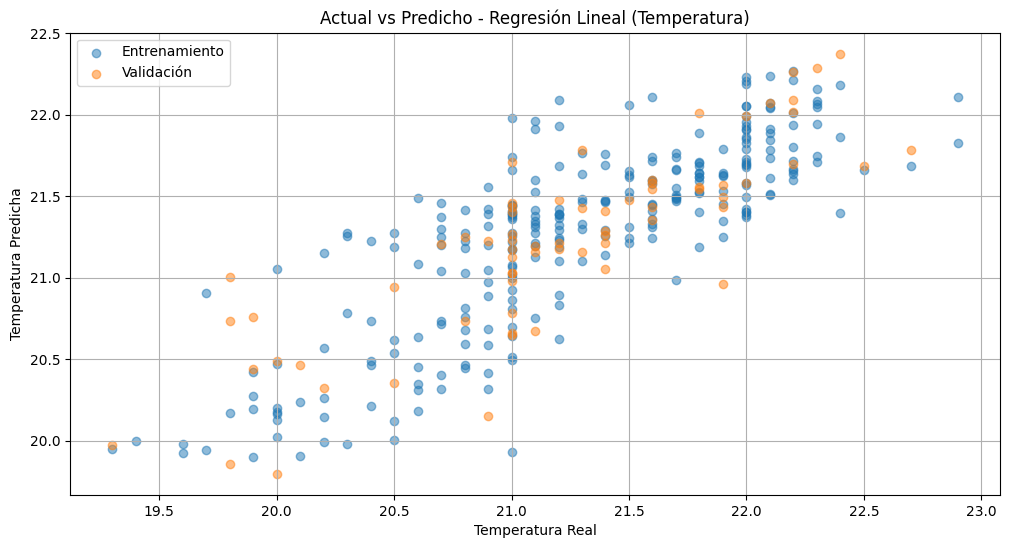

In [35]:
# Actual vs Predicho (Entrenamiento y Validación) - Regresión Lineal (Temperatura)
plt.figure(figsize=(12, 6))
plt.scatter(y_train, y_train_pred, alpha=0.5, label='Entrenamiento')
plt.scatter(y_val, y_val_pred, alpha=0.5, label='Validación')
plt.xlabel('Temperatura Real')
plt.ylabel('Temperatura Predicha')
plt.title('Actual vs Predicho - Regresión Lineal (Temperatura)')
plt.legend()
plt.grid(True)
plt.show()

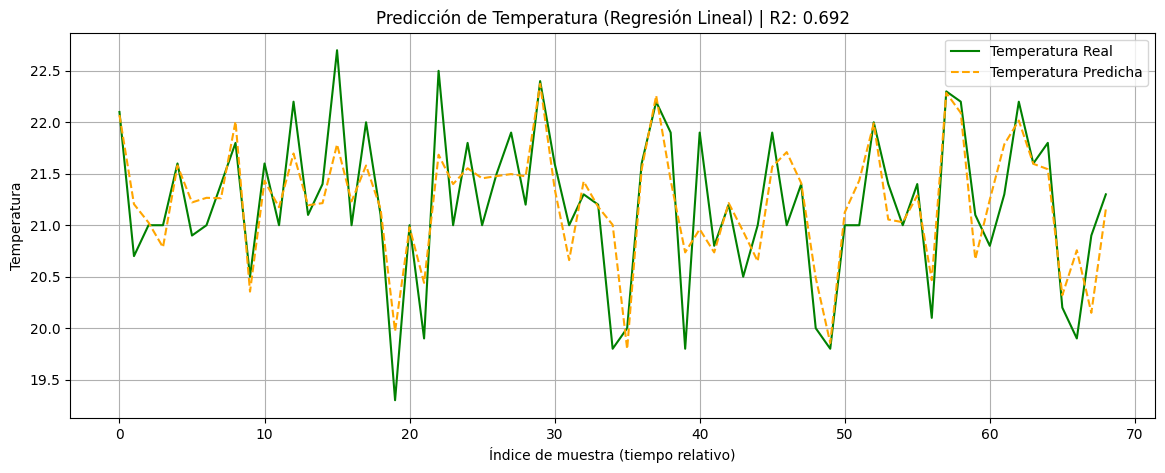

In [36]:
# Serie temporal: Temperatura real vs predicha (validación)
plt.figure(figsize=(14,5))
plt.plot(np.arange(len(y_val)), y_val, label='Temperatura Real', color='green')
plt.plot(np.arange(len(y_val_pred)), y_val_pred, label='Temperatura Predicha', color='orange', linestyle='--')
plt.xlabel('Índice de muestra (tiempo relativo)')
plt.ylabel('Temperatura')
plt.title(f'Predicción de Temperatura (Regresión Lineal) | R2: {r2_score(y_val, y_val_pred):.3f}')
plt.legend()
plt.grid(True)
plt.show()